# Image Captioning
This project uses an adaptation of the transformer model architecture described in [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044) to create an image captioner. The decoder is primarily constructed from attention layers, using self-attention to process the sequence being generated, and using cross-attention to attend to the image.

This notebook mostly follows along with [Image Captioning with Visual Attention](https://www.tensorflow.org/tutorials/text/image_captioning). It is an end-to-end process, which includes the data collection process, extracting and caching the image features, and training an image captioning decoder model, as well as using the model to generate captions on new images.

## Dependency Installation
Install packages required for the project in the environment.

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 3 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,392 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (58.8 MB/s)
(Reading database ... 123991 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.1.1.33-1+cuda11.2 to 

In [2]:
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install einops

Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Successfully uninstalled keras-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 588.3 MB 6.8 kB/s 
     |████████████████████████████████| 4.7 MB 44.7 MB/s 
     |████████████████████████████████| 6.0 MB 47.7 MB/s 
     |████████████████████████████████| 1.7 MB 47.6 MB/s 
     |████████████████████████████████| 439 kB 66.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.

## Importing Packages
Import required Python packages for the project. Most of these will be used for loading the datasets.

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import einops
import requests
import tqdm
from PIL import Image

import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

## Data Collection and Preparation
This section downloads the [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) captions dataset and prepares it for training. It also includes the input text tokenisation process and caching the results of running all the images through a pretrained feature-extractor model.

In [4]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)
  dataset_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'
  text_link = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
  num_max = 16197

  if len(list(path.rglob('*'))) < num_max:
    tf.keras.utils.get_file(origin=dataset_link, cache_dir='.', cache_subdir=path, extract=True)
    tf.keras.utils.get_file(origin=text_link, cache_dir='.', cache_subdir=path, extract=True)

  captions = (path/'Flickr8k.token.txt').read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  caption_dict = collections.defaultdict(list)

  for fname, caption in captions:
    caption_dict[fname].append(caption)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), caption_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), caption_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

Download the Flickr8k dataset.

In [5]:
train_raw, test_raw = flickr8k()

2340801/2340801 [==============================] - 0s 0us/step


Inspect an example. Note that the Flickr8k dataset contains 5 captions per image.

In [6]:
for path, caption in train_raw.take(1):
  print(path)
  print(caption)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### Feature Extraction
We will be using the pretrained MobileNetV3 model for feature extraction. Set `include_top=False` to return the model without the final classification layer.

In [7]:
IMAGE_SHAPE = (224, 224, 3)

mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE, 
    include_top=False,
    include_preprocessing=True)

mobilenet.trainable = False

4334752/4334752 [==============================] - 0s 0us/step


Add a function for reading an image and resizing it.

In [8]:
def load_image(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE[:-1])
  return img

Test the `load_image` function.

In [9]:
test_image_batch = load_image(path)[tf.newaxis, :]

print(test_image_batch.shape)
print(mobilenet(test_image_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Caption Preprocessing
the `TextVectorization` layer to transform the text captions into integer sequences.

In [10]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [11]:
vocabulary_size = 5000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)

Learn the vocabulary from the caption data.

In [12]:
tokenizer.adapt(train_raw.map(lambda path, text: text).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

Test the tokenizer.

In [14]:
t = tokenizer([['a robot dog']])

print(t)

<tf.RaggedTensor [[3, 2, 1937, 10, 4]]>


Create mappings for words to indices and indices to words.

In [15]:
word_to_index = tf.keras.layers.StringLookup(mask_token='', vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token='', vocabulary=tokenizer.get_vocabulary(), invert=True)

In [16]:
w = index_to_word(t)

print(w.to_list())

[[b'[START]', b'a', b'robot', b'dog', b'[END]']]


In [17]:
sentences = tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

print(sentences)

[b'[START] a robot dog [END]']


### Dataset Preparation
Add a function that replicates the image so there are 1:1 images to captions.

In [18]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [19]:
for path_batch, caption_batch in train_raw.batch(32).take(1):
  break

print('image paths:', path_batch.shape)
print('captions:', caption_batch.shape)
print()

path_batch, caption_batch = match_shapes(path_batch, caption_batch)

print('image paths:', path_batch.shape)
print('captions:', caption_batch.shape)

image paths: (32,)
captions: (32, 5)

image paths: (160,)
captions: (160,)


To make the input compatible with the transformer model, add a function that converts an `(images, texts) `pair to an `((images, input_tokens), label_tokens)` pair.

In [20]:
def prepare_text(images, texts):
  tokens = tokenizer(texts)
  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (images, input_tokens), label_tokens

Add a function for extraining the image features.

In [21]:
def extract_features(inputs, labels):
  (images, input_tokens) = inputs
  return (mobilenet(images), input_tokens), labels

Add a utility function for converting inputs and labels to tensors.

In [22]:
def to_tensor(inputs, labels):
    (images, input_tokens), label_tokens = inputs, labels
    return (images, input_tokens.to_tensor()), label_tokens.to_tensor()

Put it all together.

In [23]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_text, tf.data.AUTOTUNE)
          .map(extract_features, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE))

Use the `prepare_dataset` function to prepare the training and test datasets.

In [24]:
train_ds = prepare_dataset(train_raw, tokenizer)

print(train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))


In [25]:
test_ds = prepare_dataset(test_raw, tokenizer)

print(test_ds.element_spec)

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))


Add functions for caching the image features.

In [26]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  new_ds = (new_ds
            .map(prepare_text, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [27]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [00:45,  4.16it/s]
32it [00:10,  3.07it/s]


Load the training and test sets.

In [28]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [29]:
print(train_ds.element_spec)

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))


In [30]:
print(test_ds.element_spec)

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))


Inspect the train dataset.

In [31]:
for inputs, labels in train_ds.take(1):
  (images, input_tokens) = inputs

print(images.shape)
print(input_tokens.shape)
print(labels.shape)

(32, 7, 7, 576)
(32, 20)
(32, 20)


The input tokens and the labels are the same, just shifted by 1 step.

In [32]:
print(input_tokens[0].numpy())
print(labels[0].numpy())

[  3 124  32  35   5   6  43   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[124  32  35   5   6  43   4   0   0   0   0   0   0   0   0   0   0   0
   0   0]


## Transfomer Decoder Model
We will use a 2-layer Transformer-decoder for this image captioning task. Note that this model assumes that the pretrained image encoder is sufficient.

### Input
After the data preparation process, the input text has already been split up into tokens and converted to sequences of IDs. Now we have to define the `SeqEmbedding` layer to learn a vector embedding for each token ID as well as an embedding for each position in the sequence.

In [33]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True
    )
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)
    x = tf.range(tf.shape(seq)[1]) # (seq)
    x = x[tf.newaxis, :] # (1, seq)
    x = self.pos_embedding(x) # (1, seq, depth)
    return self.add([seq, x])

### Transformer Decoder
The decoder consists of a stack of `DecoderLayers` where each contains three sublayers, including a `CausalSelfAttention` layer, a `CrossAttention` layer, and a `FeedForward` layer.

#### Causal Self Attention Layer
The following class implements the Causal Self Attention layer.

In [34]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x, use_causal_mask=True)
    x = self.add([x, attn])
    x = self.layernorm(x)
    return x

#### Cross Attention Layer
The implementation of the Cross Attention layer is below. Note the use of `return_attention_scores`.

In [35]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, context, **kwargs):
    attn, attention_scores = self.mha(query=x, value=context, return_attention_scores=True)
    self.last_attention_scores = attention_scores
    x = self.add([x, attn])
    x = self.layernorm(x)
    return x

#### Feed Forward Layer
Below is the Feed Forward layer. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the batch and sequence axes.

In [36]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units*2, activation='relu'),
        tf.keras.layers.Dense(units),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    x = self.layernorm(x)
    return x

#### Decoder Layer
With the three components defined, we can now combine them into a larger `DecoderLayer`. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualisations.

In [37]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.feed_forward = FeedForward(units=units, dropout_rate=dropout_rate)

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs
    out_seq = self.self_attention(out_seq)
    out_seq = self.cross_attention(out_seq, in_seq)
    self.last_attention_scores = self.cross_attention.last_attention_scores
    out_seq = self.feed_forward(out_seq)
    return out_seq

### Output
We will need at least a Dense layer in the output layer to generate logit-predictions for each token at each location. Here we will also include an `adapt` method to count the tokens and set the optimal initial bias to reduce the initial loss.

In [38]:
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    self.dense = tf.keras.layers.Dense(tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens
    self.bias = None
  
  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    x = x + self.bias
    return x

In [39]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:06<00:00, 135.50it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Building the Model
Having defined all the required components, we can now build the image captioner model.

To make the model more flexible about the input, we will include the following conditions in the `call` function:
* If the image has 3 channels run it through the `feature_extractor`. Otherwise assume that it has been already
* If the text has the data type of `tf.string` run it through the tokeniser.

In [40]:
class ImageCaptioner(tf.keras.Model):
  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.tokenizer = tokenizer
    self.feature_extractor = feature_extractor
    self.word_to_index = tf.keras.layers.StringLookup(mask_token='', 
                                                      vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(mask_token='', 
                                                      vocabulary=tokenizer.get_vocabulary(),
                                                      invert=True)
    self.seq_embedding = SeqEmbedding(vocab_size=tokenizer.vocabulary_size(),
                                      depth=units,
                                      max_length=max_length)
    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for _ in range(num_layers)
    ]

    self.output_layer = output_layer

  def call(self, inputs):
    image, caption = inputs

    if image.shape[-1] == 3:
      image = self.feature_extractor(image)

    image = einops.rearrange(image, 'b h w c -> b (h w) c')

    if caption.dtype == tf.string:
      caption = tokenizer(caption)

    caption = self.seq_embedding(caption)

    for decoder_layer in self.decoder_layers:
      caption = decoder_layer((image, caption))

    caption = self.output_layer(caption)

    return caption
  
  def gen(self, image, temperature=1, max_length=50):
    initial = self.word_to_index([['START']]) # (batch, sequence)
    image_features = self.feature_extractor(image[tf.newaxis, ...])
    tokens = initial

    for _ in range(max_length):
      predictions = self((image_features, tokens)).numpy() # (batch, sequence, vocab)
      predictions = predictions[:, -1, :]

      if temperature == 0:
        next = tf.argmax(predictions, axis=-1)[:, tf.newaxis] # (batch, 1)
      else:
        next = tf.random.categorical(predictions/temperature, num_samples=1) # (batch, 1)

      tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

      if next[0] == self.word_to_index('[END]'):
        break

    words = index_to_word(tokens[0, 1:-1])
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    return result.numpy().decode()

Create a image captioner model.

In [41]:
model = ImageCaptioner(tokenizer=tokenizer,
                       feature_extractor=mobilenet,
                       output_layer=output_layer,
                       units=256,
                       dropout_rate=0.5,
                       num_layers=2,
                       num_heads=2)

Try to use the untrained model to generate a caption. The resulting captions are expected to not make any sense at this stage.

In [88]:
image_path = 'drive/MyDrive/ImageCaptioning/Images/pedestrian.jpg'
image = load_image(image_path)

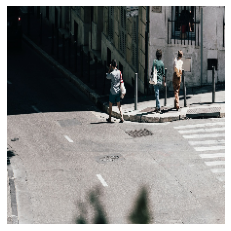

In [89]:
plt.imshow(image/255)
plt.axis('off')
plt.show()

In [43]:
for temperature in (0.0, 0.5, 1.):
  result = model.gen(image, temperature)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a and in dog is
teenage with in is boy a drinks skate on cyclist a


## Model Training
In order to train the model, we will have to define several components, including the loss function and metrics, the optimiser and some additional callbacks.

### Loss Function and Metrics
The following is an implementation of a masked loss and accuracy.

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [44]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For some feedback during training, add a callback that generates some captions for a sample image at the end of each epoch.

In [45]:
class GenerateCaption(tf.keras.callbacks.Callback):
  def __init__(self):
    image_path = 'drive/MyDrive/ImageCaptioning/Images/pedestrian.jpg'
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for temperature in (0.0, 0.5, 1.0):
      result = self.model.gen(self.image, temperature=temperature)
      print(result)
    print()

Test the callback.

In [46]:
gen_callback = GenerateCaption()
gen_callback.model = model
gen_callback.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a

leg



Define a callback for saving checkpoints during training.

In [47]:
BATCH_SIZE = 32

checkpoint_dir = 'drive/MyDrive/ImageCaptioning/training/training_01'
checkpoint_path = os.path.join(checkpoint_dir, 'cp-{epoch:04d}.ckpt')

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*BATCH_SIZE)

If applicable, load the previously saved weights.

In [48]:
if os.path.exists(checkpoint_dir) and len(os.listdir(checkpoint_dir)) > 0:
  latest = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(latest)

Also use `callbacks.EarlyStopping` to terminate training when the model starts to overfit.

In [49]:
callbacks = [
    GenerateCaption(),
    cp_callback,
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

### Training
Configure the model for training.

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=masked_loss,
              metrics=[masked_acc])

Print the summary of the model architecture.

In [51]:
model.summary()

Model: "image_captioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  multiple                 0         
 torization)                                                     
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 string_lookup_3 (StringLook  multiple                 0         
 up)                                                             
                                                                 
 string_lookup_4 (StringLook  multiple                 0 (unused)
 up)                                                             
                                                                 
 seq_embedding (SeqEmbedding  multiple             

Train the model.

For more frequent reporting, use the `Dataset.repeat()` method, and set the `steps_per_epoch` and `validation_steps` arguments to `Model.fit`.

In [52]:
history = model.fit(train_ds.repeat(),
                    steps_per_epoch=100,
                    validation_data=test_ds.repeat(),
                    validation_steps=20,
                    epochs=100,
                    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 4.9831 - masked_acc: 0.2035

a man in a red a man

on a monk

100/100 [==============================] - 30s 174ms/step - loss: 4.9831 - masked_acc: 0.2035 - val_loss: 4.6727 - val_masked_acc: 0.2457
Epoch 2/100
 59/100 [================>.............] - ETA: 2s - loss: 4.6555 - masked_acc: 0.2538
Epoch 2: saving model to drive/MyDrive/ImageCaptioning/training/training_01/cp-0002.ckpt
100/100 [==============================] - ETA: 0s - loss: 4.6188 - masked_acc: 0.2571

a man in a red shirt on a red
a man in a red wearing a dog on a and a air
violin toddler against a theater of a running young

100/100 [==============================] - 10s 104ms/step - loss: 4.6188 - masked_acc: 0.2571 - val_loss: 4.3275 - val_masked_acc: 0.2827
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.4127 - masked_acc: 0.2793



hockey young people of a little girl bin

100/100 [==============================] - 1

Plot the loss and accuracy over the training run.

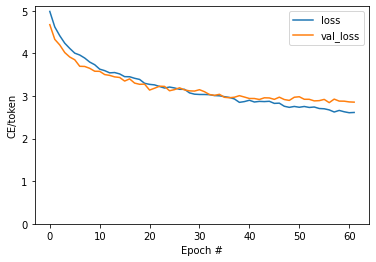

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

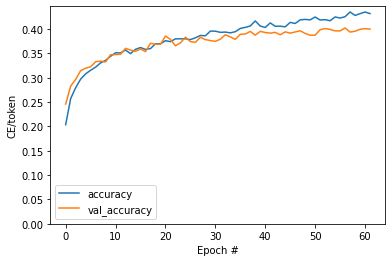

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention Plots
Having trained the model, try using it to generate a caption for the image.

In [90]:
result = model.gen(image, temperature=0.0)
print(result)

a man is walking on a sidewalk


Retrieve last attention scores from each decoder layers. Note that the shape of each attention map is `(batch=1, heads, sequence, image)`.

In [66]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 8, 49]), TensorShape([1, 2, 8, 49])]

So stack the maps along the `batch` axis, then average over the `(batch, heads)` axes, while splitting the `image` axis back into `height, width`.

In [67]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

Now we should have only one attention map for each sequence prediction. The values in each map should sum up to 1.

In [68]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        ], dtype=float32)>

Add a function for plotting attention maps.

In [69]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)

    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

Split the output back into tokens.

In [70]:
str_tokens = result.split()
str_tokens.append('[END]')

Try plotting the attention maps for the input image.

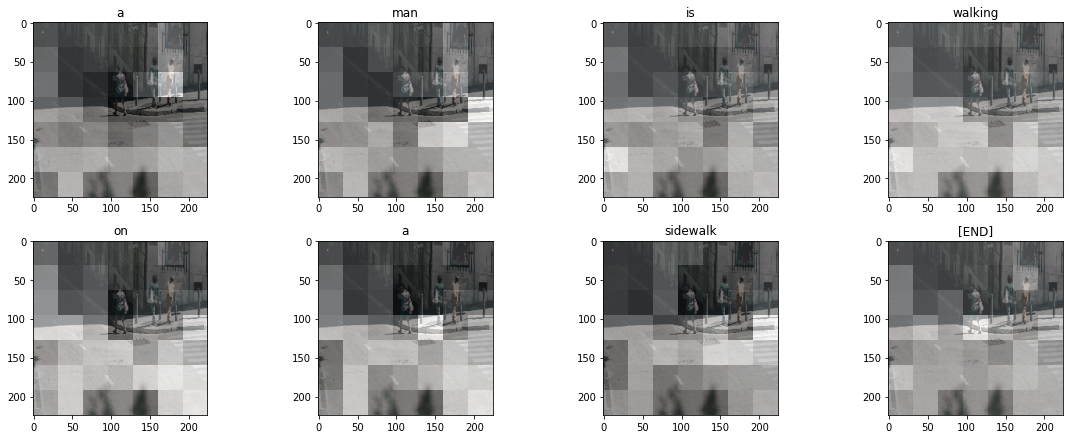

In [71]:
plot_attention_maps(image/255, str_tokens, attention_maps)

Put it all together into a single function.

In [74]:
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

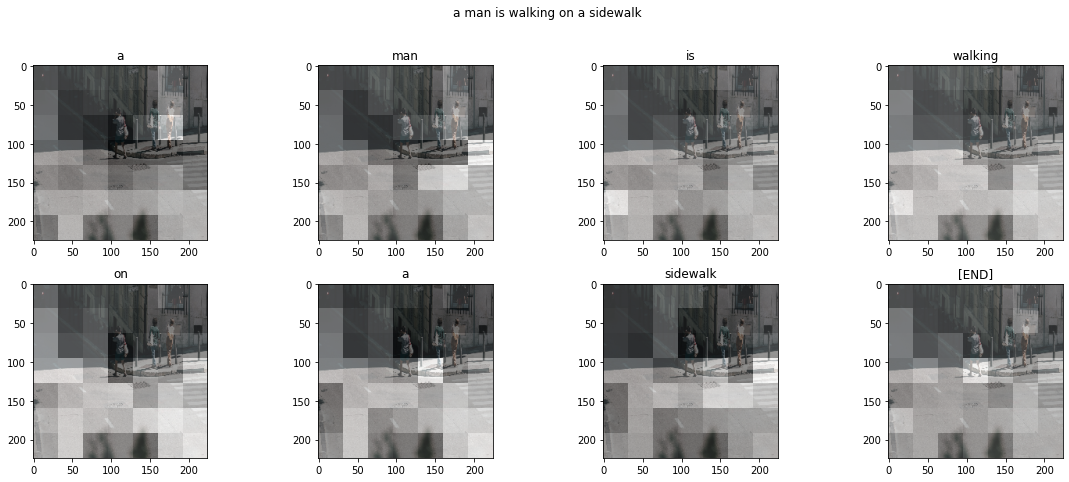

In [75]:
run_and_show_attention(model, image)

Now try using the model to caption a different image.

In [119]:
image_path = 'drive/MyDrive/ImageCaptioning/Images/beach.jpg'
image = load_image(image_path)

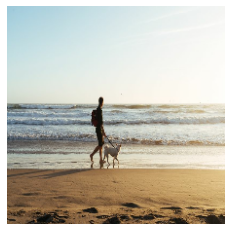

In [128]:
plt.imshow(image/255)
plt.axis('off')
plt.show()

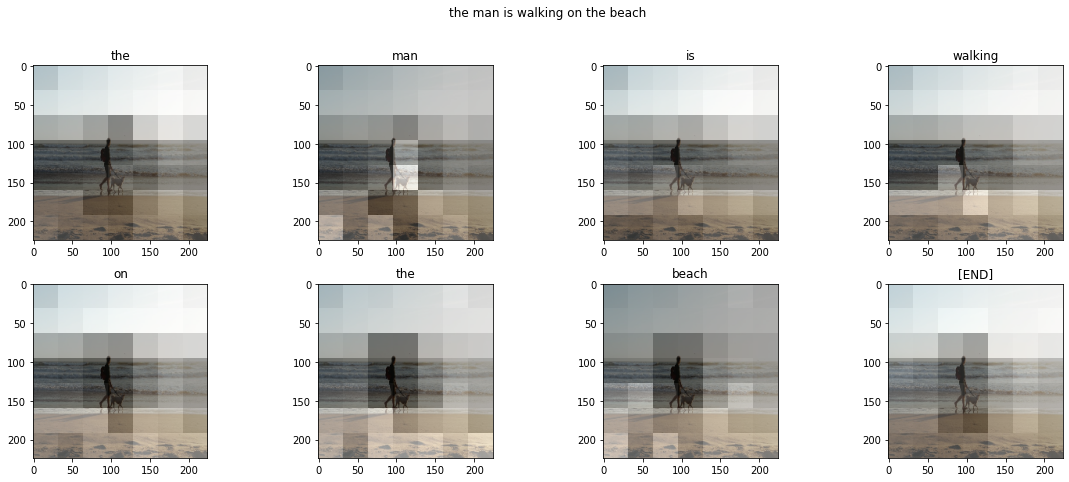

In [121]:
run_and_show_attention(model, image)